# [DM 2025/26] Phoneme Classification

In [1]:
# Library importing

## ML
import sklearn.datasets as skl
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN

import numpy as np
import pandas as pd

## Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

## Utilities
import csv
import json
import os

## Models
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve

## 0. Utilities

In [2]:
def save_csv_dataset(data: pd.DataFrame, save_name: str):
    
    if not save_name.endswith('.csv'):
        save_name += '.csv'
    
    data.to_csv(save_name, index=False, encoding='utf-8')
    abs_path = os.path.abspath(save_name)
    
    print(f"Dataset salvato in: {abs_path}")
    print(f"Righe: {len(data)}, Colonne: {len(data.columns)}")
    
    return abs_path

## 1. Dataset Analysis

In [3]:
# Dataset import
dataset = fetch_openml(name="phoneme", version=1)

# Isolating features and labels
data = dataset.data
labels = dataset.target

# Taking feature names and label names
feature_names = dataset.feature_names
label_counts = np.unique_counts(labels)

In [4]:
data.head()

,V1,V2,V3,V4,V5
0,0.489927,-0.451528,-1.047990,-0.598693,-0.020418
1,-0.641265,0.109245,0.292130,-0.916804,0.240223
2,0.870593,-0.459862,0.578159,0.806634,0.835248
3,-0.628439,-0.316284,1.934295,-1.427099,-0.136583
4,-0.596399,0.015938,2.043206,-1.688448,-0.948127


In [5]:
labels.value_counts()

Class
1    3818
2    1586
Name: count, dtype: int64

In [6]:
# Extracting statistics on data
data.describe()

,V1,V2,V3,V4,V5
count,5.404000e+03,5.404000e+03,5.404000e+03,5.404000e+03,5.404000e+03
mean,3.330866e-09,5.551443e-09,6.106588e-09,-9.437454e-09,-6.698742e-08
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.933743e+00,-3.038709e+00,-2.795869e+00,-2.485340e+00,-2.367461e+00
25%,-6.697555e-01,-7.790800e-01,-9.505788e-01,-7.583255e-01,-5.405418e-01
50%,-3.801605e-01,-2.150985e-01,-3.861800e-02,-1.422555e-01,-2.127475e-01
75%,3.149040e-01,7.136990e-01,7.771393e-01,6.759035e-01,2.045420e-01
max,3.828575e+00,3.664763e+00,2.630868e+00,3.046948e+00,4.586666e+00


From the statistical report we notice that all the features have mean equal to zero and standard deviation equal to 1, so they are already standard scaled.

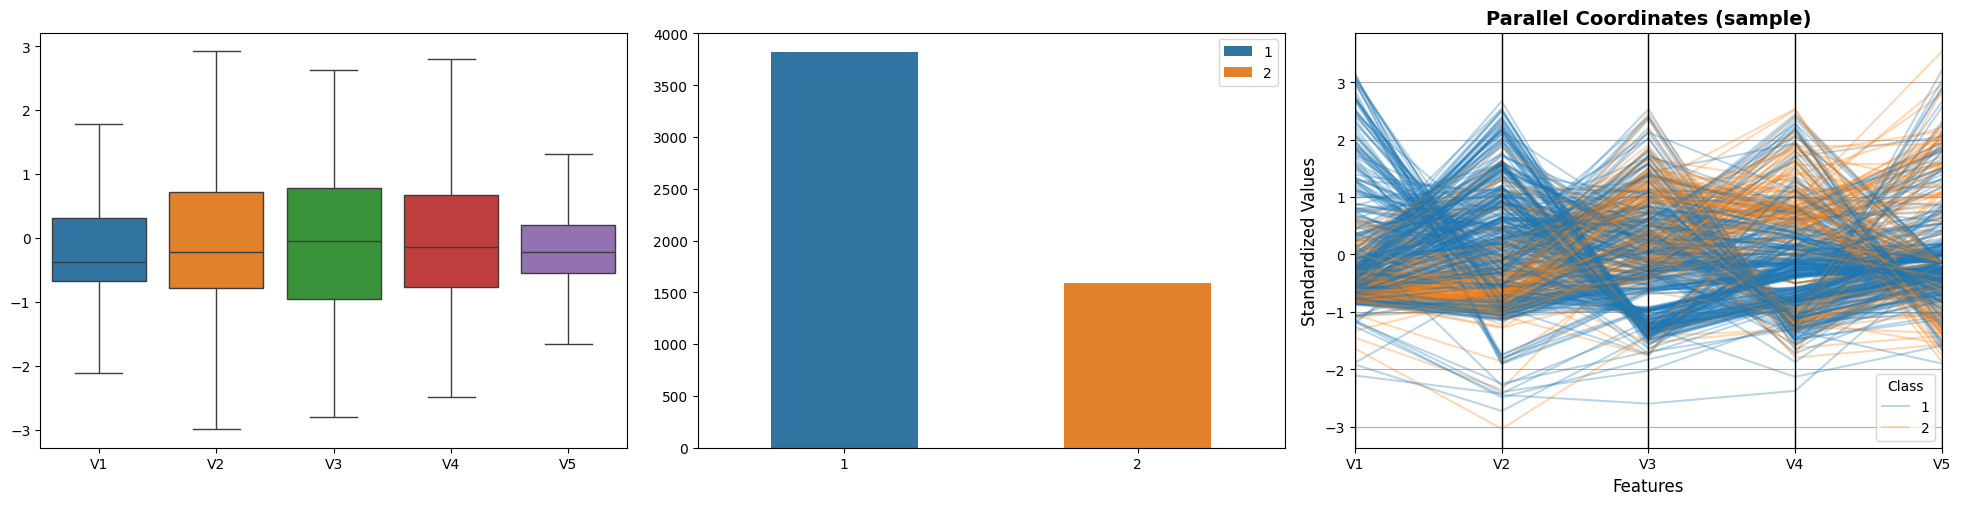

In [7]:
# Creating 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.tight_layout(pad=2)

# Boxplot -> feature distribution 
sns.boxplot(data, 
            palette="tab10", 
            showfliers=False, 
            ax=axs[0]
            )

# Barplot -> class distribution
sns.barplot(x=label_counts.values, 
            y=label_counts.counts, 
            palette="tab10", 
            hue=label_counts.values, 
            legend=True,
            width=0.5, 
            ax=axs[1]
			)

# Building a temporary dataframe with information about classes (necessary for parallel coordinates)
df = data.copy()
df["class"] = labels

# Campiona per rendere il grafico leggibile
df_sample = df.sample(n=min(500, len(df)), random_state=42)

parallel_coordinates(
    frame=df_sample,  # Usa campione
    class_column="class",
    color=sns.color_palette("tab10", n_colors=2),
    ax=axs[2],
    alpha=0.3  # Trasparenza per vedere meglio
)
axs[2].set_title("Parallel Coordinates (sample)", fontsize=14, fontweight='bold')
axs[2].set_xlabel("Features", fontsize=12)
axs[2].set_ylabel("Standardized Values", fontsize=12)
axs[2].legend(title='Class', loc='best')
plt.show()

The class distribution shows that the two classes are highly imbalanced with class 1 being represented for more than twice class 2, this suggests need for future preprocessing aimed to balance the class frequency.

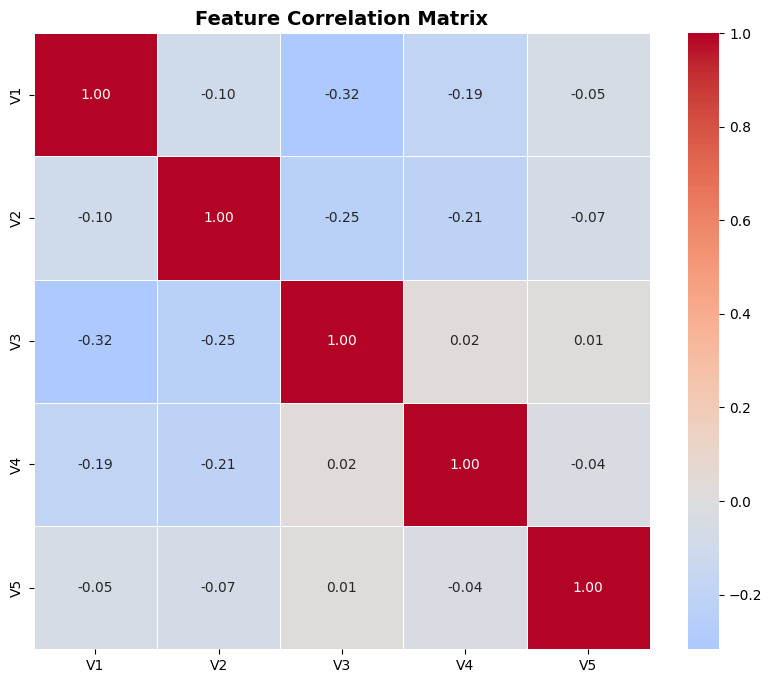

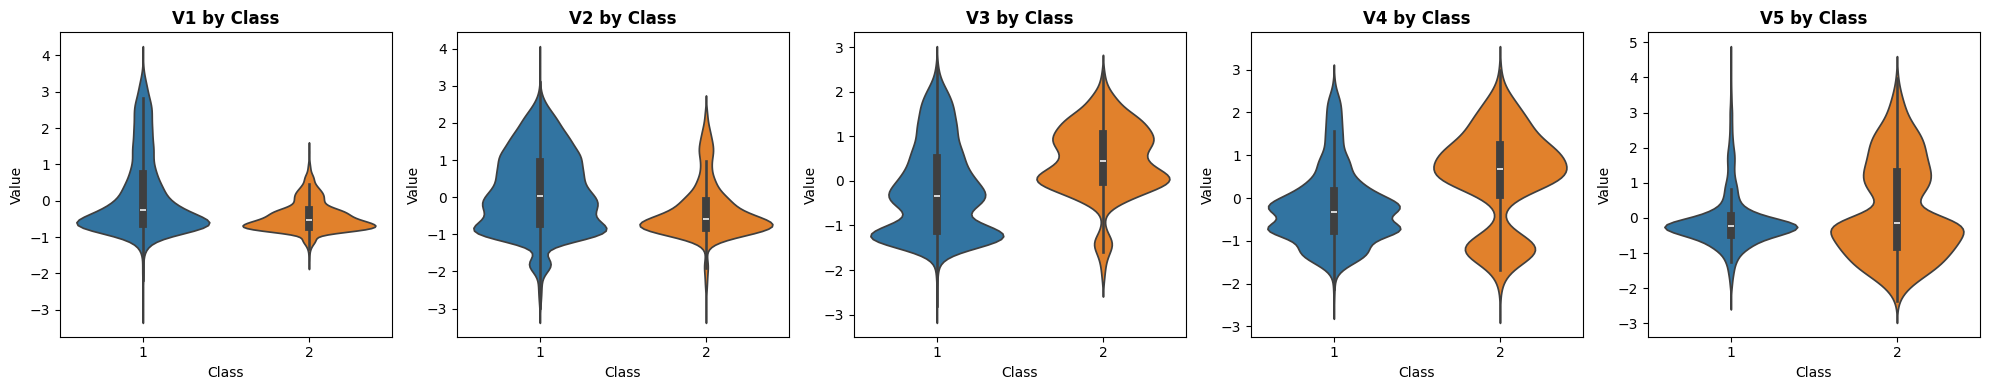

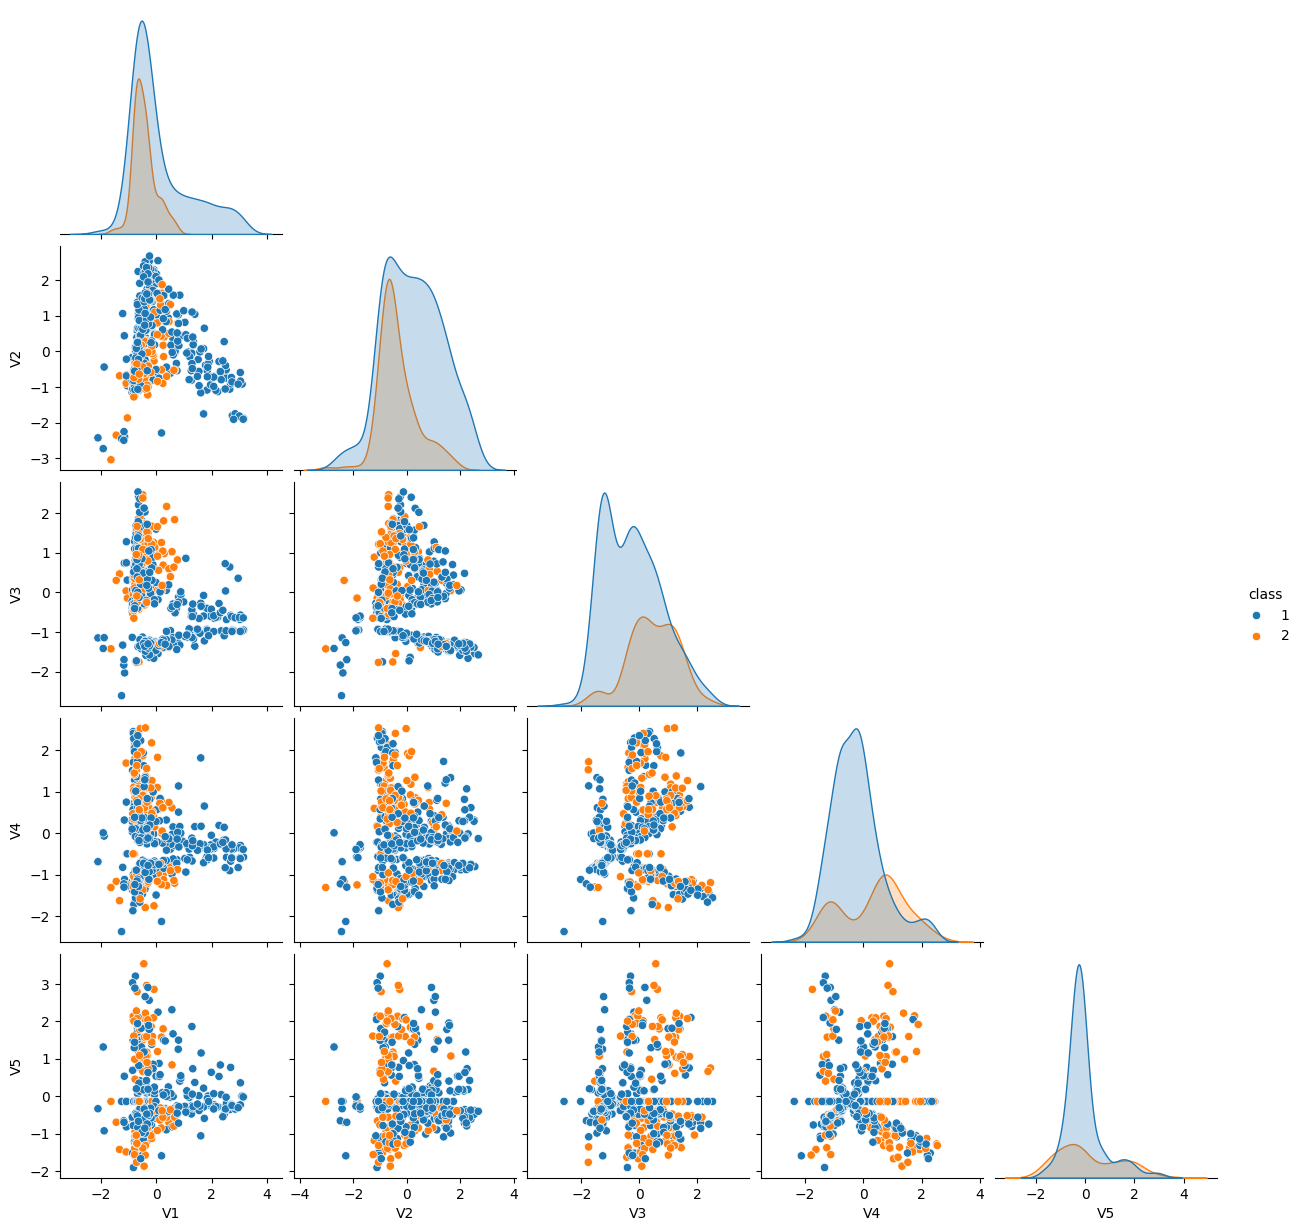

In [8]:
#  CORRELAZIONE TRA FEATURES
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=0.5)
plt.title("Feature Correlation Matrix", fontsize=14, fontweight='bold')
plt.show()

# DISTRIBUZIONE PER CLASSE (violin plot)
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx, col in enumerate(data.columns):
    df_plot = data.copy()
    df_plot['class'] = labels
    sns.violinplot(data=df_plot, 
                   x='class', 
                   y=col, 
                   hue='class',  
                   palette='tab10', 
                   legend=False,  
                   ax=axes[idx])
    axes[idx].set_title(f'{col} by Class', fontweight='bold')
    axes[idx].set_xlabel('Class')
    axes[idx].set_ylabel('Value')
plt.tight_layout()
plt.show()

#PAIRPLOT 
df_sample = data.sample(n=500, random_state=42).copy()
df_sample['class'] = labels[df_sample.index]
sns.pairplot(df_sample, hue='class', palette='tab10', diag_kind='kde', corner=True)
plt.show()

## 2. Preprocessing

In [9]:
# Preprocessing variables
RANDOM_SEED = 42
TRAIN_SIZE = 0.75

### 2.1 Missing values handling

In [10]:
data.isna().describe()

,V1,V2,V3,V4,V5
count,5404,5404,5404,5404,5404
unique,1,1,1,1,1
top,False,False,False,False,False
freq,5404,5404,5404,5404,5404


### 2.2 Train-Test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=TRAIN_SIZE, random_state=RANDOM_SEED)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4053, 5), (1351, 5), (4053,), (1351,))

In [12]:
X_train.to_csv("data/X_train.csv", sep=",", index=False)
X_test.to_csv("data/X_test.csv", sep=",", index=False)
y_train.to_csv("data/y_train.csv", sep=",", index=False)
y_test.to_csv("data/y_test.csv", sep=",", index=False)

### 2.3 Balancing

In [13]:
under_sampler = RandomUnderSampler(random_state=RANDOM_SEED)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)
y_train_under[y_train_under=="1"].shape, y_train_under[y_train_under=="2"].shape

((1196,), (1196,))

In [14]:
X_train_under.to_csv("data/X_train_under.csv", sep=",", index=False)
y_train_under.to_csv("data/y_train_under.csv", sep=",", index=False)

In [15]:
over_sampler = ADASYN(random_state=RANDOM_SEED)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
y_train_over[y_train_over=="1"].shape, y_train_over[y_train_over=="2"].shape

((2857,), (2960,))

In [16]:
X_train_over.to_csv("data/X_train_over.csv", sep=",", index=False)
y_train_over.to_csv("data/y_train_over.csv", sep=",", index=False)

### 2.3 Reduction

#### 2.3.1 PCA reduction

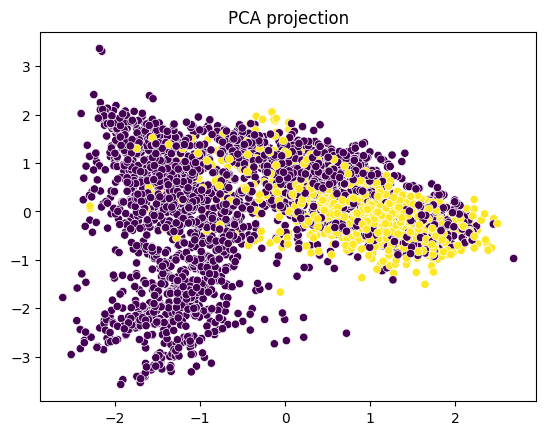

((4053, 2), (1351, 2))

In [17]:
from sklearn.decomposition import PCA

pca_reductor = PCA(n_components=2, random_state=RANDOM_SEED)

# Fitting PCA reductor ONLY with train data to avoid data leakage
X_train_pca = pca_reductor.fit_transform(X_train)

# Transforming test data with reductor fitted on train data
X_test_pca = pca_reductor.transform(X_test)

pca_plot = sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:,1], c=y_train.values.astype(int))
pca_plot.set_title("PCA projection")
plt.show()

X_train_pca.shape, X_test_pca.shape

#### 2.3.2 LDA reduction

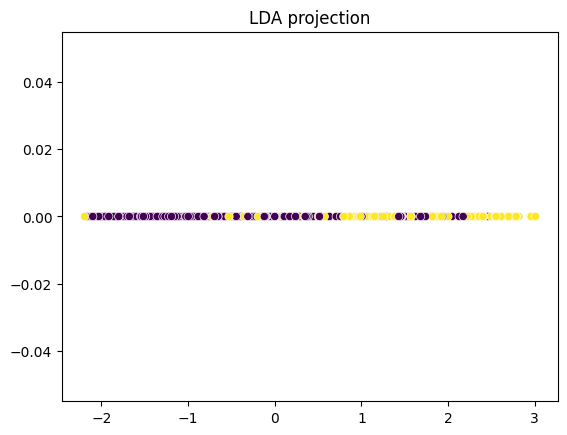

((4053, 1), (1351, 1))

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda_reductor = LDA(n_components=1)	# n_components cannot be larger than min(n_features, n_classes - 1) = min(5, 1)

# Fitting PCA reductor ONLY with train data to avoid data leakage
X_train_lda = lda_reductor.fit_transform(X_train, y_train)

# Transforming test data with reductor fitted on train data
X_test_lda = lda_reductor.transform(X_test)

lda_plot = sns.scatterplot(x=X_train_lda[:, 0], y=np.zeros(shape=X_train_lda.shape[0]), c=y_train.values.astype(int))
lda_plot.set_title("LDA projection")
plt.show()

X_train_lda.shape, X_test_lda.shape

#### 2.3.3 t-SNE reduction

over sampling 

## 3. Classification

In [59]:
# models = {
#     "DecisionTree": {
#         "instance": DecisionTreeClassifier(random_state=RANDOM_SEED),
# 	},
#     "NaiveBayes": {
#         "instance": GaussianNB(),
# 	},
#     "KNN": {
#         "instance": KNeighborsClassifier(),
# 	},
# 	"SVC": {
# 		"instance": SVC(random_state=RANDOM_SEED),
# 	},
#     "MLP": {
#         "instance": MLPClassifier(random_state=RANDOM_SEED),
# 	},
#     "RandomForest": {
#         "instance": RandomForestClassifier(random_state=RANDOM_SEED),
# 	},
#     "AdaBoost": {
#         "instance": AdaBoostClassifier(random_state=RANDOM_SEED),
# 	},
#     "XGBoost": {
#         "instance": XGBClassifier(),
# 	}
# }

models = {
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_SEED),
    "NaiveBayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
	"SVC": SVC(random_state=RANDOM_SEED),
    "MLP": MLPClassifier(random_state=RANDOM_SEED),
    "RandomForest": RandomForestClassifier(random_state=RANDOM_SEED),
    "AdaBoost": AdaBoostClassifier(random_state=RANDOM_SEED),
    "XGBoost": XGBClassifier(),
}

models = {
    name: {
        sampling: istance for sampling, istance in zip(("over", "under", "none"), [models[name]] * 3)
	} for name in models.keys()
}

In [60]:
# Importing the file of the tuned iperparameters
with open("./tuned_hyperparameters.json", mode="r") as file:
	hyperparameters = json.load(file)



for model in models.keys():
	for sampling in ("over", "under", "none"):
		models.get(model).get(sampling).set_params(**hyperparameters.get(sampling).get(model).get("params"))
		print(f"{model}-{sampling}: {models.get(model).get(sampling).get_params()}")

print(type(models))

DecisionTree-over: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 19, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
DecisionTree-under: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 19, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
DecisionTree-none: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 24, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
NaiveBayes-over: {'priors': None, 'va

### 3.1 Shallow Machine Learning

#### 3.1.1 Decision Tree

normal dataset 

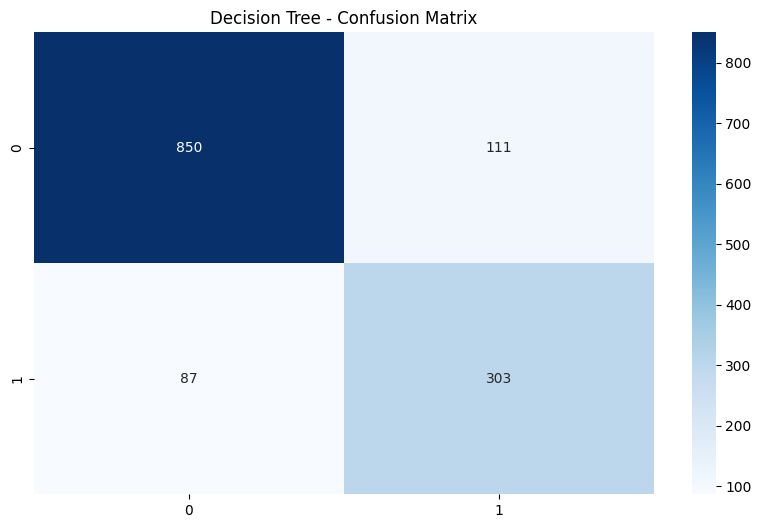

Accuracy: 0.8534418948926721
              precision    recall  f1-score   support

           1       0.91      0.88      0.90       961
           2       0.73      0.78      0.75       390

    accuracy                           0.85      1351
   macro avg       0.82      0.83      0.82      1351
weighted avg       0.86      0.85      0.85      1351



In [ ]:
# dt = DecisionTreeClassifier(max_depth=None, random_state=42, criterion='gini')
dt = models.get("DecisionTree").get("none")
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt="d")
plt.title("Decision Tree - Confusion Matrix")
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

ROC-AUC: 0.8307091971504041


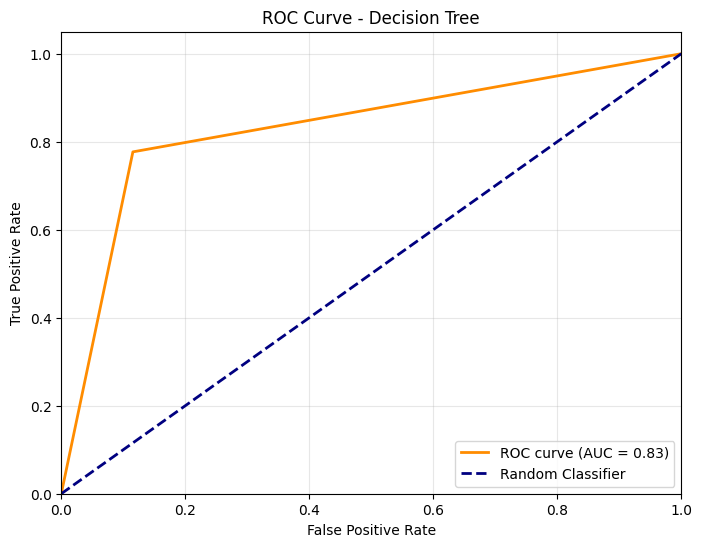

In [20]:
y_pred_proba = dt.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC:", roc_auc)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='2')

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

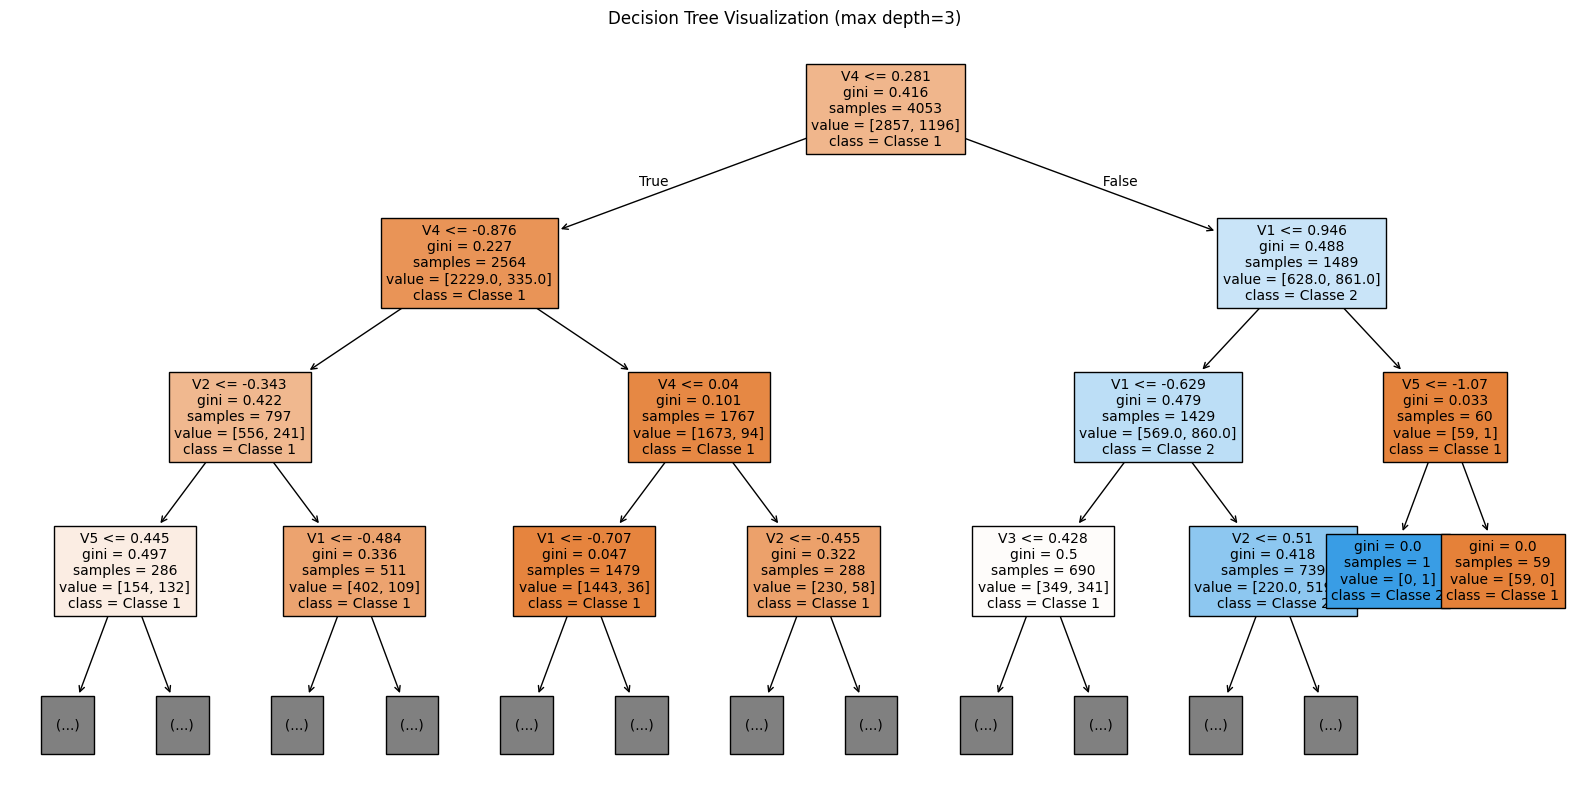

In [21]:
plt.figure(figsize=(20, 10))
plot_tree(dt, 
          feature_names=dataset.feature_names,
          class_names=['Classe 1', 'Classe 2'],  
          filled=True, 
          max_depth=3,
          fontsize=10)
plt.title("Decision Tree Visualization (max depth=3)")
plt.show()

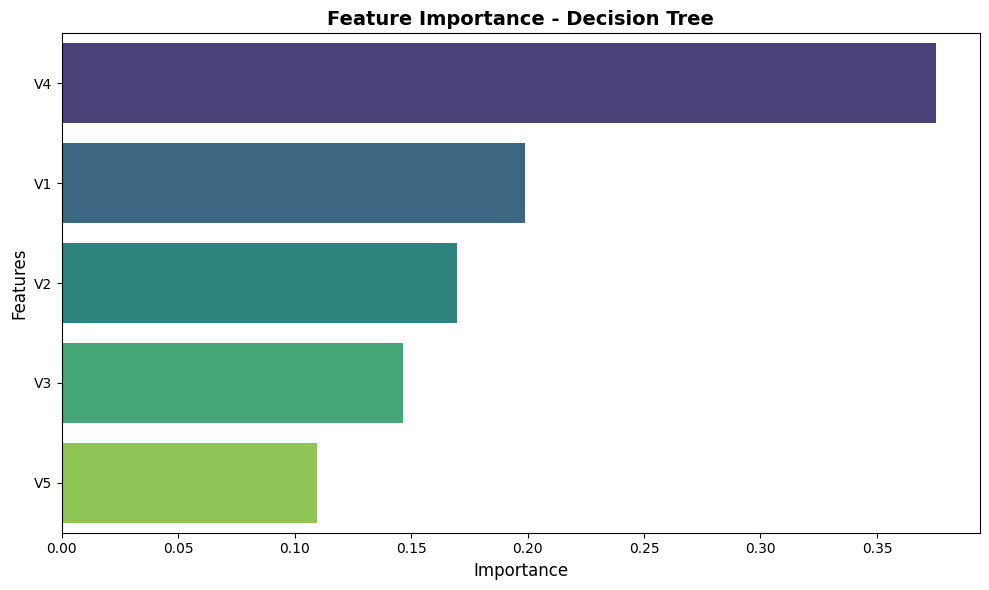


Feature Importance Ranking:
feature  importance
     V4    0.375462
     V1    0.198756
     V2    0.169524
     V3    0.146462
     V5    0.109797


In [22]:
feature_importance = pd.DataFrame({
    'feature': data.columns,
    'importance': dt.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, 
            x='importance', 
            y='feature', 
            hue='feature',  
            palette='viridis',
            legend=False)  
plt.title("Feature Importance - Decision Tree", fontsize=14, fontweight='bold')
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
print(feature_importance.to_string(index=False))

oversampling 

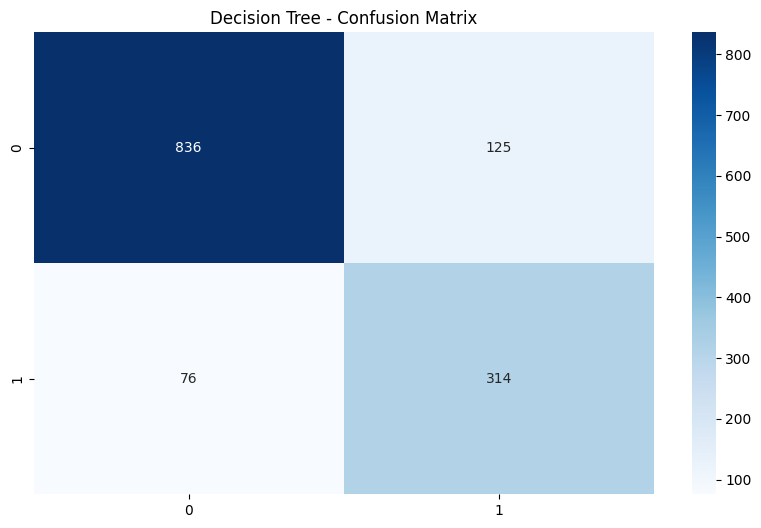

Accuracy: 0.851221317542561
              precision    recall  f1-score   support

           1       0.92      0.87      0.89       961
           2       0.72      0.81      0.76       390

    accuracy                           0.85      1351
   macro avg       0.82      0.84      0.83      1351
weighted avg       0.86      0.85      0.85      1351



In [66]:

# dt = DecisionTreeClassifier(max_depth=None, random_state=42, criterion='gini')
dt = models.get("DecisionTree").get("over")
dt.fit(X_train_over, y_train_over)

y_pred = dt.predict(X_test)

plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt="d")
plt.title("Decision Tree - Confusion Matrix")
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

ROC-AUC: 0.8507937778489287


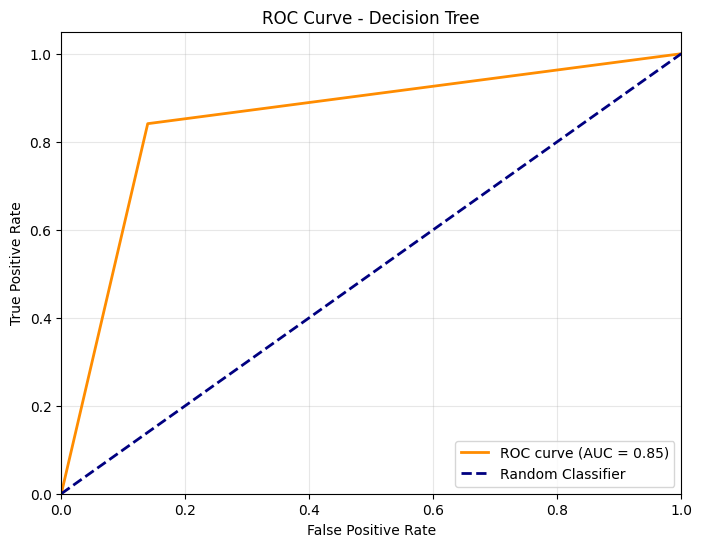

In [24]:
y_pred_proba = dt.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC:", roc_auc)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='2')

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

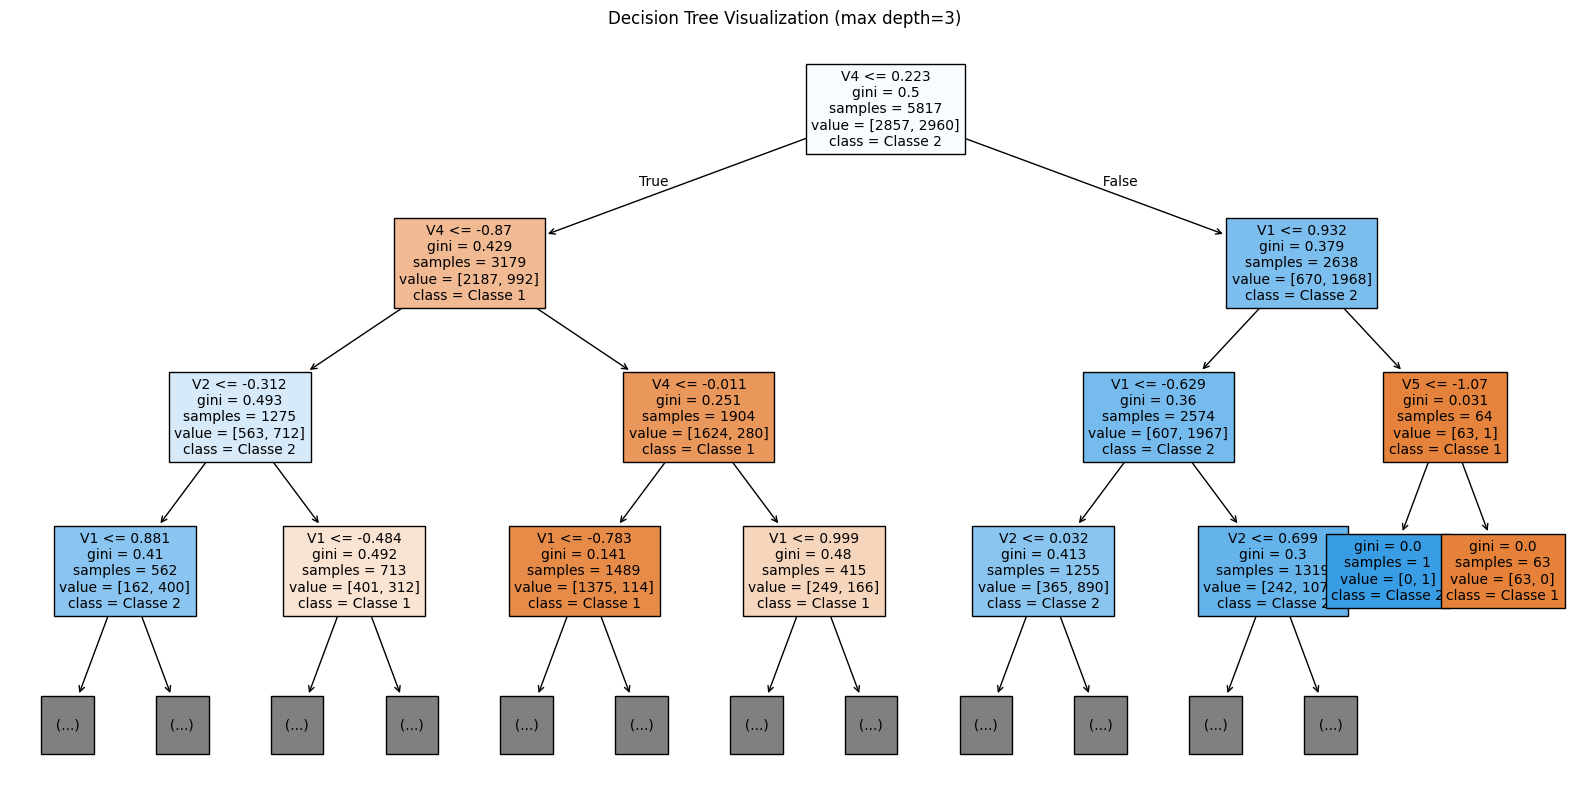

In [25]:
plt.figure(figsize=(20, 10))
plot_tree(dt, 
          feature_names=dataset.feature_names,
          class_names=['Classe 1', 'Classe 2'],  
          filled=True, 
          max_depth=3,
          fontsize=10)
plt.title("Decision Tree Visualization (max depth=3)")
plt.show()

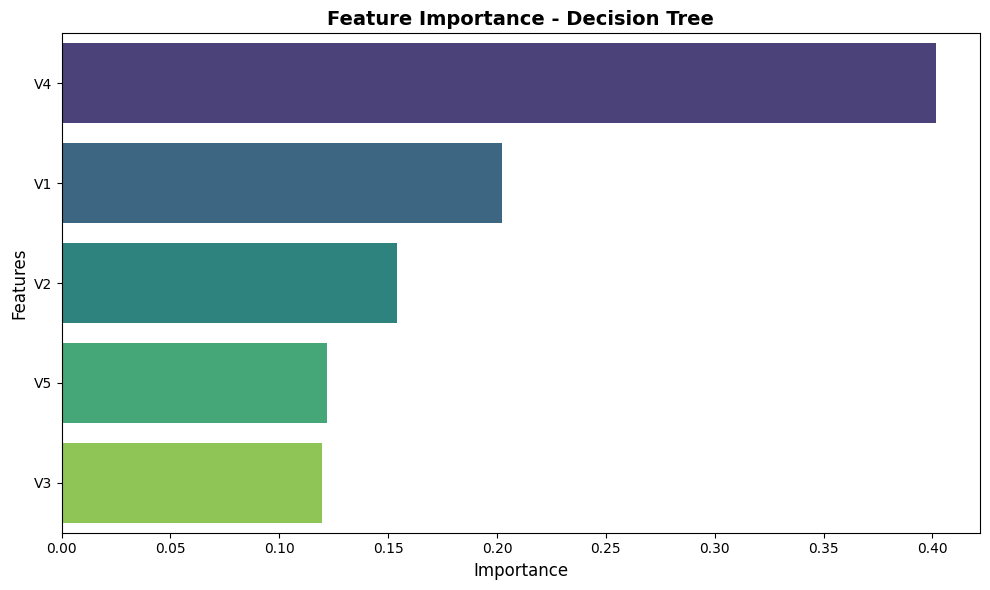


Feature Importance Ranking:
feature  importance
     V4    0.401800
     V1    0.202352
     V2    0.153974
     V5    0.122118
     V3    0.119756


In [26]:
feature_importance = pd.DataFrame({
    'feature': data.columns,
    'importance': dt.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, 
            x='importance', 
            y='feature', 
            hue='feature',  
            palette='viridis',
            legend=False)  
plt.title("Feature Importance - Decision Tree", fontsize=14, fontweight='bold')
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
print(feature_importance.to_string(index=False))

undersampling

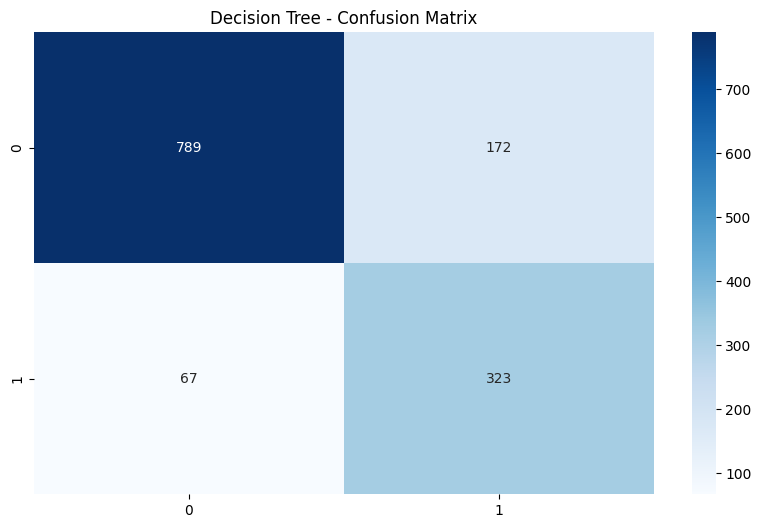

Accuracy: 0.8230940044411547
              precision    recall  f1-score   support

           1       0.92      0.82      0.87       961
           2       0.65      0.83      0.73       390

    accuracy                           0.82      1351
   macro avg       0.79      0.82      0.80      1351
weighted avg       0.84      0.82      0.83      1351



In [67]:

# dt = DecisionTreeClassifier(max_depth=None, random_state=42, criterion='gini')
dt = models.get("DecisionTree").get("under")
dt.fit(X_train_under, y_train_under)

y_pred = dt.predict(X_test)

plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt="d")
plt.title("Decision Tree - Confusion Matrix")
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

ROC-AUC: 0.8257824381653727


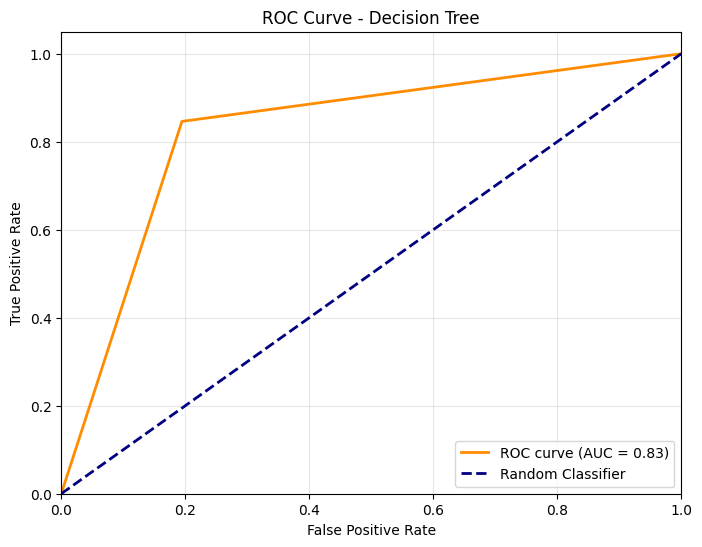

In [28]:
y_pred_proba = dt.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC:", roc_auc)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='2')

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

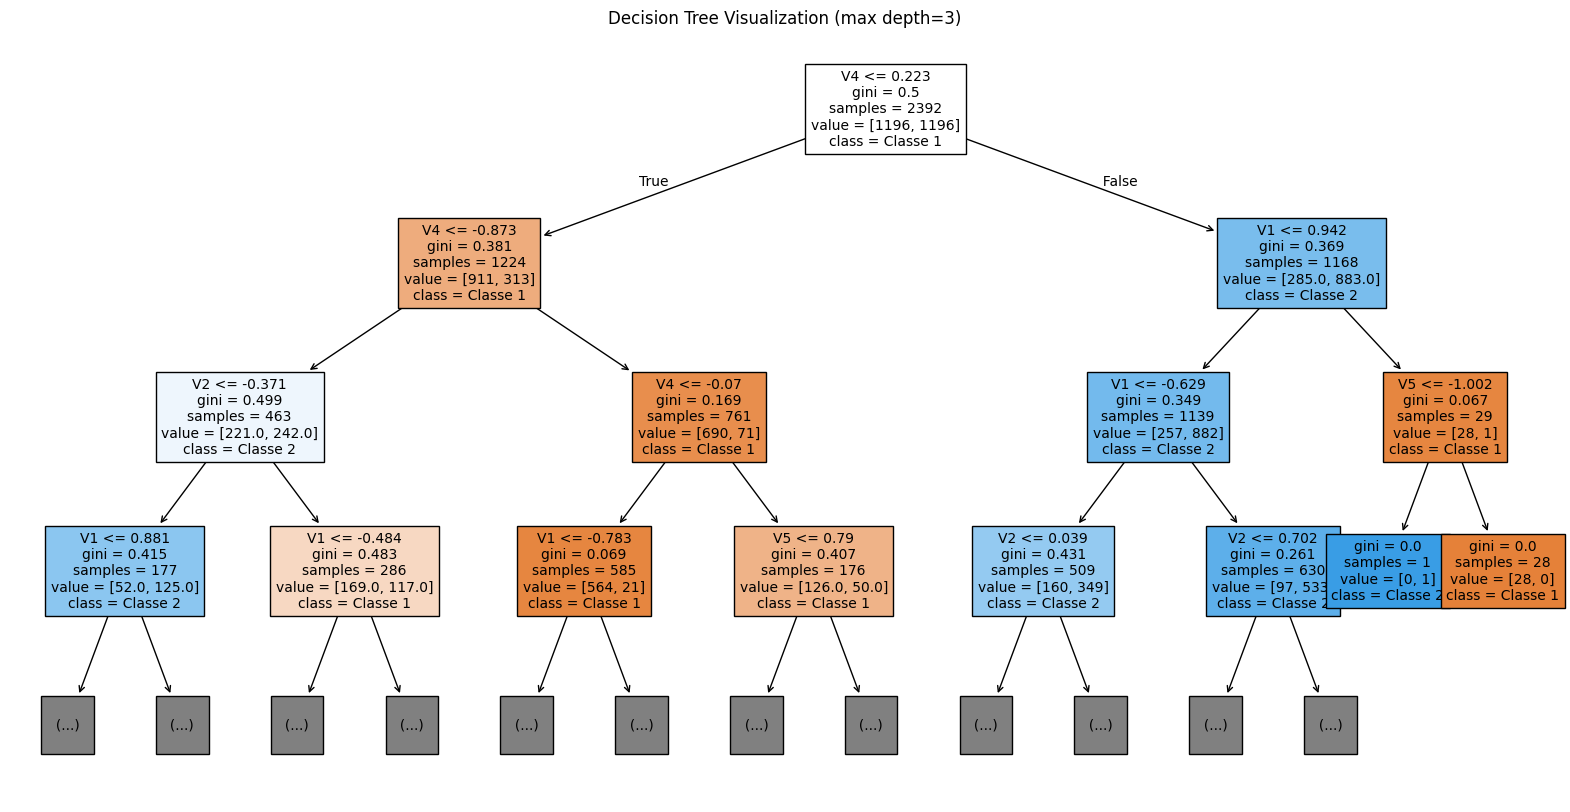

In [29]:
plt.figure(figsize=(20, 10))
plot_tree(dt, 
          feature_names=dataset.feature_names,
          class_names=['Classe 1', 'Classe 2'],  
          filled=True, 
          max_depth=3,
          fontsize=10)
plt.title("Decision Tree Visualization (max depth=3)")
plt.show()

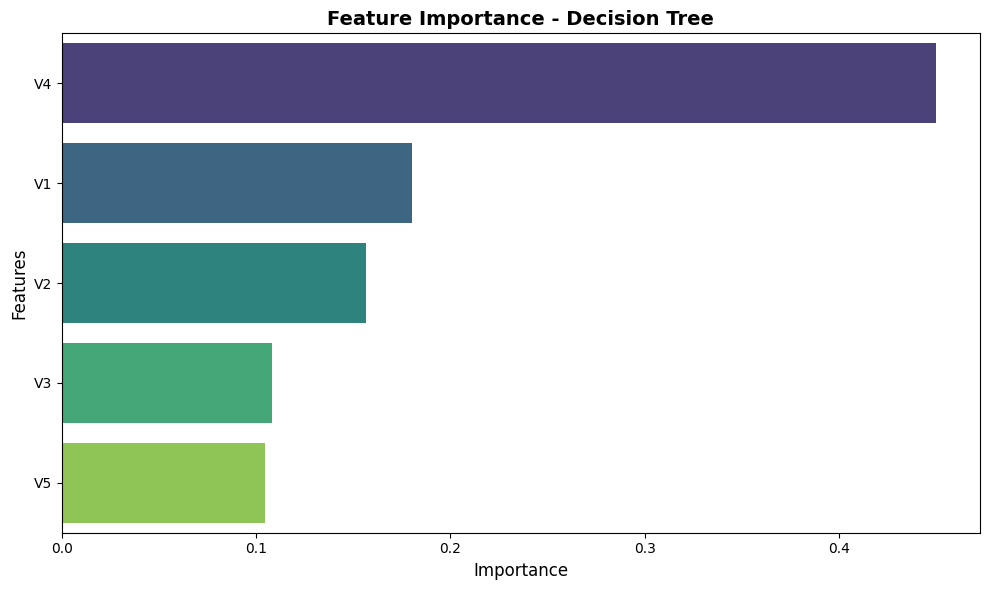


Feature Importance Ranking:
feature  importance
     V4    0.450112
     V1    0.180518
     V2    0.156659
     V3    0.108267
     V5    0.104445


In [30]:
feature_importance = pd.DataFrame({
    'feature': data.columns,
    'importance': dt.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, 
            x='importance', 
            y='feature', 
            hue='feature',  
            palette='viridis',
            legend=False)  
plt.title("Feature Importance - Decision Tree", fontsize=14, fontweight='bold')
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
print(feature_importance.to_string(index=False))

Selected feature indices: [0 1 2 3 4]


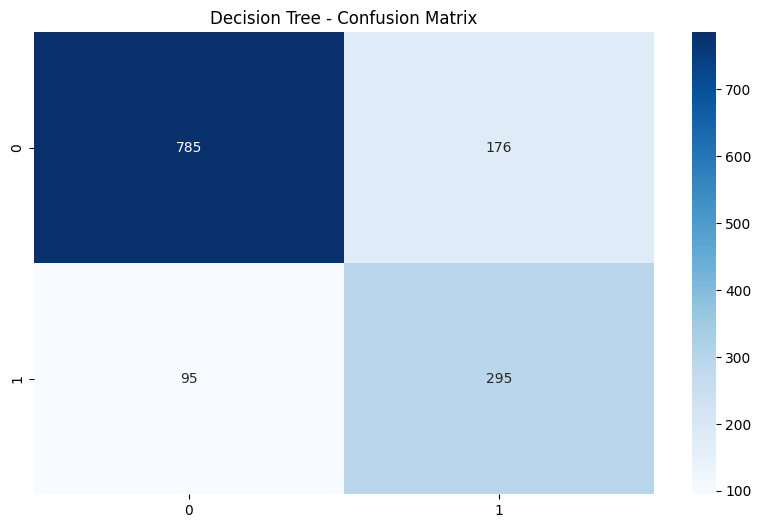

Accuracy: 0.7994078460399704
              precision    recall  f1-score   support

           1       0.89      0.82      0.85       961
           2       0.63      0.76      0.69       390

    accuracy                           0.80      1351
   macro avg       0.76      0.79      0.77      1351
weighted avg       0.82      0.80      0.80      1351



In [31]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=3)
X_train_selected = selector.fit_transform(X_train_over, y_train_over)
X_test_selected = selector.transform(X_test)
importances = dt.feature_importances_
indices = np.where(importances > 0.05)[0]  
print("Selected feature indices:", indices)
# train the decision tree classifier    
dt = DecisionTreeClassifier(max_depth=None, random_state=42, criterion='gini')
dt.fit(X_train_selected, y_train_over)

y_pred = dt.predict(X_test_selected)    

plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt="d")
plt.title("Decision Tree - Confusion Matrix")
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#### 3.1.3 KNN Classifier

#### 3.1.4 SVM Classifier

### 3.2 Ensemble Classifiers Machine Learning 

#### 3.2.2 AdaBoost

#### 3.2.3 Extreme Gradient Boosting

#### 3.2.4 Custom Ensemble

### 3.3 Deep Learning

#### 3.3.1 Multi Layer Perceptron

## 4. Evaluation

## 5. Result Discussion